<a href="https://colab.research.google.com/github/CraigDuncan/CID1020/blob/master/ECE50024Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Run
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
!pip install higher

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random
import math
import copy
import itertools
import higher

In [4]:
def nineAndFourDataset(train_dataset, test_dataset, split = 0.995, train_size = 5000, meta_size=10):

  #training set disproportionat
  num4s = int(train_size * split)  #majority of dataset
  num9s = train_size-num4s 
  train4locs = train_dataset.targets==4
  train9locs = train_dataset.targets==9
  train4data = train_dataset.data[train4locs][:num4s] #slice to size needed
  train9data = train_dataset.data[train9locs][:num9s]
  train_data = torch.cat((train4data, train9data))
  train_targets = torch.cat((torch.zeros(len(train4data)),torch.ones(len(train9data))))
  train_dataset.data = train_data
  train_dataset.targets = train_targets

  meta_dataset = copy.deepcopy(train_dataset)
  meta4locs = meta_dataset.targets==0
  meta9locs = meta_dataset.targets==1
  meta4data = meta_dataset.data[meta4locs][:(meta_size//2)] #slice to size needed
  meta9data = meta_dataset.data[meta9locs][:(meta_size//2)]
  meta_data = torch.cat((meta4data,meta9data))
  meta_targets = torch.cat((torch.zeros(len(meta4data)),torch.ones(len(meta9data)))) #len better than using meta_size/2 to ensure no rounding issues
  meta_dataset.data = meta_data
  meta_dataset.targets = meta_targets

  test4locs = test_dataset.targets==4
  #print(len(test4locs))
  test9locs = test_dataset.targets==9
  #print(len(test9locs))
  test4data = test_dataset.data[test4locs] #[:num4s] #slice to size needed
  test9data = test_dataset.data[test9locs] #[:num9s]
  test_data = torch.cat((test4data, test9data))
  test_targets = torch.cat((torch.zeros(len(test4data)),torch.ones(len(test9data))))
  test_dataset.data = test_data
  test_dataset.targets = test_targets

  return train_dataset, meta_dataset, test_dataset


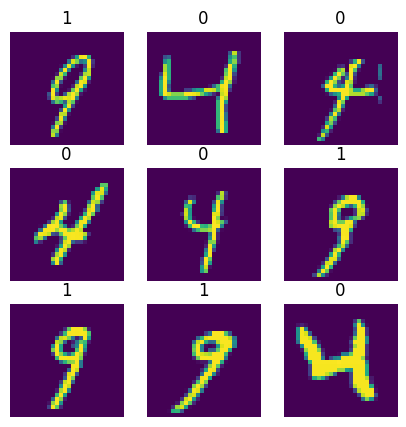

In [16]:
# Create MNIST datasets
classes = np.arange(10)
transform = torchvision.transforms.Compose(
  [torchvision.transforms.ToTensor(),
   torchvision.transforms.Normalize((0.1307,),(0.3081,))])
train_dataset_base = torchvision.datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset_base = torchvision.datasets.MNIST('./data', train=False, download=True, transform=transform)

meta_size = 10
train_dataset, meta_dataset, test_dataset = nineAndFourDataset(copy.deepcopy(train_dataset_base), copy.deepcopy(test_dataset_base), split=.95, meta_size=meta_size)
# Create dataloaders
batch_size_train, batch_size_test = 100, 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)
meta_loader = torch.utils.data.DataLoader(meta_dataset, batch_size=100, shuffle=True)
meta_loader = itertools.cycle(meta_loader)
meta_data = torch.autograd.Variable(meta_dataset.data, requires_grad=False)
meta_labels = torch.autograd.Variable(meta_dataset.targets, requires_grad=False)

# Show sample images
batch_idx, (images, targets) = next(enumerate(meta_loader))
fig, ax = plt.subplots(3,3,figsize = (5,5))
for i in range(3):
  for j in range(3):
    image = images[i*3+j].permute(1,2,0)
    image = image/2 + 0.5
    ax[i,j].imshow(image.squeeze(2))
    ax[i,j].set_title(f'{classes[targets[i*3+j]]}')
    ax[i,j].axis('off')
fig.show()

In [20]:
#defines train test and assessModel methods
def train(epoch, model, optimizer):
    model.train() # we need to set the mode for our model
    for batch_idx, (images, targets) in enumerate(train_loader):
      images = images.to(device)
      targets = targets.to(device)
      optimizer.zero_grad()
      output = model(images)
      #loss = F.cross_entropy(output, targets.type_as(output)) # Here is a typical loss function (negative log likelihood)
      BCELoss.reduction = 'sum'
      loss = BCELoss(output, targets.type_as(output))
      loss.backward()
      optimizer.step()
      if batch_idx % 1000 == 0: # We visulize our output every 10 batches
        print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item()}')


def test_old(epoch, model):
  model.eval() # we need to set the mode for our model
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for images, targets in test_loader:
      images = images.to(device)
      targets = targets.to(device)
      output = model(images)
      test_loss += F.cross_entropy(output, targets.type_as(output), reduction='sum').item()
      pred = output #output.data.max(1, keepdim=True)[1] # we get the estimate of our result by look at the largest class value
      correct += pred.eq(targets.data.view_as(pred)).sum() # sum up the corrected samples
  test_loss /= len(test_loader.dataset)
  print(f'Test result on epoch {epoch}: Avg loss is {test_loss}, Accuracy: {100.*correct/len(test_loader.dataset)}%')
  return 100.*correct/len(test_loader.dataset)

# ----------- <Your code> ---------------
def assessModel():
  model = basicModel()
  model.to(device)
  optimizerADAM = optim.Adam(params = model.parameters(), lr = 0.001)
  max_epoch = 100
  accuracy=[]
  for epoch in range(1, max_epoch+1):
    train(epoch, model, optimizerADAM)
    accuracy.append( test(epoch, model).detach().cpu().numpy())
  return accuracy


In [7]:
class basicModel(nn.Module):
    def __init__(self):
      super().__init__()
      self.final_size = 640
      self.input_Conv = nn.Conv2d(1, 6, kernel_size=3, stride=1)
      self.pool1=nn.MaxPool2d(kernel_size=3,stride=1, padding=0)
      self.conv5 = nn.Conv2d(6, 10, kernel_size=5, stride=1, padding=0)
      self.pool2 =  nn.MaxPool2d(kernel_size=3,stride=1, padding=0)
      self.reduction = nn.Conv2d(10, 10, kernel_size=3, stride=1)
      self.pool3 =  nn.MaxPool2d(kernel_size=2)
      self.fc = nn.Linear(self.final_size,320) #nn.Linear(784, 10) - minst
      self.fc2 = nn.Linear(320,1) #nn.Linear(784, 10) - minst

    def forward(self, x):
      x = self.input_Conv(x)
      x = self.pool1(x)
      x = F.relu(self.conv5(x))
      x = self.pool2(x)
      x = F.relu(self.reduction(x)) #reduction convolution to help shrink to final return size 10 
      out = self.pool3(x)
      x = out.view(-1,self.final_size)#out.view(-1, 784)      # x now has shape (batchsize x 432)
      x = F.relu(self.fc(x))     # x has shape (batchsize x 10)
      x = self.fc2(x).squeeze()
      return x #F.log_softmax(x,-1) #cant use on bianary

In [ ]:
print(assessModel())

Epoch 1: [0/5000] Loss: 0.7043796181678772
Test result on epoch 1: Avg loss is 0.693147181267118, Accuracy: 49.32194900512695%
Epoch 2: [0/5000] Loss: 0.6931471824645996
Test result on epoch 2: Avg loss is 0.693147181267118, Accuracy: 49.32194900512695%
Epoch 3: [0/5000] Loss: 0.6931471824645996
Test result on epoch 3: Avg loss is 0.693147181267118, Accuracy: 49.32194900512695%
Epoch 4: [0/5000] Loss: 0.6931471824645996
Test result on epoch 4: Avg loss is 0.693147181267118, Accuracy: 49.32194900512695%
Epoch 5: [0/5000] Loss: 0.6931471824645996
Test result on epoch 5: Avg loss is 0.693147181267118, Accuracy: 49.32194900512695%
Epoch 6: [0/5000] Loss: 0.6931471824645996
Test result on epoch 6: Avg loss is 0.693147181267118, Accuracy: 49.32194900512695%
Epoch 7: [0/5000] Loss: 0.6931471824645996
Test result on epoch 7: Avg loss is 0.693147181267118, Accuracy: 49.32194900512695%
Epoch 8: [0/5000] Loss: 0.6931471824645996
Test result on epoch 8: Avg loss is 0.693147181267118, Accuracy: 49.

TypeError: ignored

In [8]:
BCELoss = nn.BCEWithLogitsLoss().to(device)

In [9]:
#defines impliment projects seudo code training process
def meta_train(epoch, model, optimizer):
    meta_lr = 1e-3
    model.train() # we need to set the mode for our model
    for batch_idx, (images, targets) in enumerate(train_loader):
      images = images.to(device)
      targets = targets.to(device)
      optimizer.zero_grad()
      with higher.innerloop_ctx(model, optimizer) as (meta_model, meta_opt):
      #meta_model = basicModel() #dummy model to cache weights for meta learning
      #meta_model.load_state_dict(model.state_dict())
      #meta_model.to(device)
      #meta_opt = optim.SGD(params = model.parameters(), lr = meta_lr)

        y_hat_f = meta_model(images)
        BCELoss.reduction='none'
        cost = BCELoss(y_hat_f, targets.type_as(y_hat_f))
        #cost = F.binary_cross_entropy_with_logits(y_hat_f, targets.type_as(y_hat_f), reduce=False)
        #epsilon = torch.autograd.Variable(torch.zeros(cost.size()), requires_grad=True).to(device)
        epsilon = torch.zeros(cost.size(), requires_grad=True, device=device)
        lf = torch.sum(epsilon*cost)
        #meta_model.zero_grad()

        #gradTheta =  torch.autograd.grad(lf, (meta_model.parameters()), create_graph=True)
      #for param, grad in zip(meta_model.parameters(), gradTheta):
      #    param.copy_(param - meta_lr * grad)
      #    #param.copy_(new_param)

      #meta_model.update_params(meta_lr, source_params=gradTheta)
      #lf.backward()
        meta_opt.step(lf)

        val_images, val_labels = next(meta_loader)
        #val_images = meta_data
        #val_labels = meta_labels
        val_images = val_images.to(device)
        val_labels = val_labels.to(device)

        y_hat_g = meta_model(val_images)
        BCELoss.reduction = 'mean'
        lg = BCELoss(y_hat_g, val_labels.type_as(y_hat_g))
        #lg = F.binary_cross_entropy_with_logits(y_hat_g,val_labels.type_as(y_hat_f))

        gradEpsilon = torch.autograd.grad(lg, epsilon)[0].detach()
      print(gradEpsilon)
      w_tilde = torch.clamp(-gradEpsilon, min=0)
      normSum = torch.sum(w_tilde)

      if normSum != 0:
          w = w_tilde / normSum
      else:
          w = w_tilde
      
      #use image weights to compute model update
      
      y_hat_f = model(images)
      BCELoss.reduction='none'
      cost = BCELoss(y_hat_f, targets.type_as(y_hat_f))
      #cost = F.binary_cross_entropy_with_logits(y_hat_f,targets.type_as(y_hat_f), reduce=False)
      l_hat_f = torch.sum(cost*w) #weighted cost
      l_hat_f.backward()
      optimizer.step()
      
      #output = model(images)
      #loss = F.cross_entropy(output, targets) # Here is a typical loss function (negative log likelihood)
      #loss.backward()
      #optimizer.step()
      if batch_idx % 1000 == 0: # We visulize our output every 10 batches
        print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {l_hat_f.item()}')
# ----------- <Your code> ---------------
def meta_assessModel():
  model = basicModel()
  model.to(device)
  optimizerADAM = optim.Adam(params = model.parameters(), lr = 0.001)
  max_epoch = 4
  accuracy=0
  for epoch in range(1, max_epoch+1):
    meta_train(epoch, model, optimizerADAM)
    accuracy = test(epoch, model).detach().cpu().numpy()
  return accuracy


In [21]:
#run this one
#defines impliment projects seudo code training process This one works
def meta_train(epoch, model, optimizer):
    meta_lr = 1e-3
    model.train() # we need to set the mode for our model
    for batch_idx, (images, targets) in enumerate(train_loader):
      images = images.to(device)
      targets = targets.to(device)
      optimizer.zero_grad()
      with higher.innerloop_ctx(model, optimizer) as (meta_model, meta_opt):
        y_hat_f = meta_model(images)
        BCELoss.reduction='none'
        cost = BCELoss(y_hat_f, targets.type_as(y_hat_f))
        
        epsilon = torch.zeros(cost.size(), requires_grad=True, device=device)
        lf = torch.sum(epsilon*cost)
        meta_opt.step(lf)

        val_images, val_labels = next(meta_loader)
        #val_images = torch.autograd.Variable(meta_data, requires_grad=False)
        #val_labels = torch.autograd.Variable(meta_labels, requires_grad=False)
        val_images = val_images.to(device)
        val_labels = val_labels.to(device)

        y_hat_g = meta_model(val_images)
        BCELoss.reduction = 'mean'
        lg = BCELoss(y_hat_g, val_labels.type_as(y_hat_g))

        gradEpsilon = torch.autograd.grad(lg, epsilon)[0].detach()

      #print(gradEpsilon)
      w_tilde = torch.clamp(-gradEpsilon, min=0)
      normSum = torch.sum(w_tilde)

      if normSum != 0:
          w = w_tilde / normSum
          #print("yay")
      else:
          w = w_tilde
      
      #use image weights to compute model update
      
      y_hat_f2 = model(images)
      BCELoss.reduction='none'
      cost = BCELoss(y_hat_f2, targets.type_as(y_hat_f2))
      #cost = F.binary_cross_entropy_with_logits(y_hat_f,targets.type_as(y_hat_f), reduce=False)
      l_hat_f = torch.sum(cost*w) #weighted cost
      l_hat_f.backward()
      optimizer.step()
      
      #output = model(images)
      #loss = F.cross_entropy(output, targets) # Here is a typical loss function (negative log likelihood)
      #loss.backward()
      #optimizer.step()
      if batch_idx % 1000 == 0: # We visulize our output every 10 batches
        print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {l_hat_f.item()}')
# ----------- <Your code> ---------------
def meta_assessModel():
  model = basicModel()
  model.to(device)
  #optimizerADAM = optim.Adam(params = model.parameters(), lr = 0.001)
  optimizerADAM = optim.SGD(model.parameters(), lr=1e-3)
  max_epoch = 100
  accuracy=[]
  for epoch in range(1, max_epoch+1):
    meta_train(epoch, model, optimizerADAM)
    accuracy.append(test(epoch, model).detach().cpu().numpy())
  return accuracy

In [11]:
def test(epoch, model):
  model.eval() # we need to set the mode for our model
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for images, targets in test_loader:
      images = images.to(device)
      targets = targets.to(device)
      output = model(images)
      test_loss +=  F.binary_cross_entropy_with_logits(output, targets.type_as(output), reduction='sum').item()
      pred = (F.sigmoid(output) > 0.5).int() #output.data.max(1, keepdim=True)[1] # we get the estimate of our result by look at the largest class value
      correct += pred.eq(targets.data.view_as(pred)).sum() # sum up the corrected samples
  test_loss /= len(test_loader.dataset)
  print(f'Test result on epoch {epoch}: Avg loss is {test_loss}, Accuracy: {100.*correct/len(test_loader.dataset)}%')
  return 100.*correct/len(test_loader.dataset)


In [22]:
meta_acc = meta_assessModel()

Epoch 1: [0/5000] Loss: 0.6819994449615479
Test result on epoch 1: Avg loss is 0.693465993010417, Accuracy: 49.32194900512695%
Epoch 2: [0/5000] Loss: 0.6855607032775879
Test result on epoch 2: Avg loss is 0.6934325957286304, Accuracy: 49.32194900512695%
Epoch 3: [0/5000] Loss: 0.6968262195587158
Test result on epoch 3: Avg loss is 0.6931691976841343, Accuracy: 49.32194900512695%
Epoch 4: [0/5000] Loss: 0.6465196013450623
Test result on epoch 4: Avg loss is 0.6927376483206411, Accuracy: 49.32194900512695%
Epoch 5: [0/5000] Loss: 0.6434763669967651
Test result on epoch 5: Avg loss is 0.6921787156584513, Accuracy: 49.32194900512695%
Epoch 6: [0/5000] Loss: 0.6558337211608887
Test result on epoch 6: Avg loss is 0.6918726489509188, Accuracy: 49.32194900512695%
Epoch 7: [0/5000] Loss: 0.6636886596679688
Test result on epoch 7: Avg loss is 0.6911707695616602, Accuracy: 49.32194900512695%
Epoch 8: [0/5000] Loss: 0.6612755060195923
Test result on epoch 8: Avg loss is 0.6906568660381629, Accura

In [23]:
#meta_acc = meta_assessModel()
base_acc = assessModel()
#print(meta_assessModel())

Epoch 1: [0/5000] Loss: 68.85884857177734
Test result on epoch 1: Avg loss is 0.7940771370183158, Accuracy: 49.32194900512695%
Epoch 2: [0/5000] Loss: 9.05081558227539
Test result on epoch 2: Avg loss is 0.06521066182046485, Accuracy: 97.99095916748047%
Epoch 3: [0/5000] Loss: 0.7275789976119995
Test result on epoch 3: Avg loss is 0.08551727031371152, Accuracy: 97.28779602050781%
Epoch 4: [0/5000] Loss: 0.031087573617696762
Test result on epoch 4: Avg loss is 0.12996155173400353, Accuracy: 95.42943572998047%
Epoch 5: [0/5000] Loss: 2.080043315887451
Test result on epoch 5: Avg loss is 0.06369702717254713, Accuracy: 98.04118347167969%
Epoch 6: [0/5000] Loss: 0.26622939109802246
Test result on epoch 6: Avg loss is 0.04196173091110783, Accuracy: 98.7945785522461%
Epoch 7: [0/5000] Loss: 0.09145542979240417
Test result on epoch 7: Avg loss is 0.04277547864811256, Accuracy: 98.7945785522461%
Epoch 8: [0/5000] Loss: 0.1986779272556305
Test result on epoch 8: Avg loss is 0.030612390239534517,

Text(0.5, 1.0, 'Model vs Baseline Testing Accuracy For 0.95 Skew')

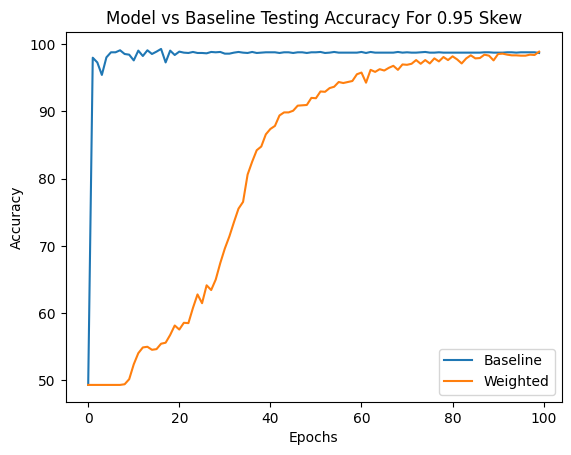

In [24]:
plt.plot(base_acc, label="Baseline")
plt.plot(meta_acc, label = "Weighted")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model vs Baseline Testing Accuracy For 0.95 Skew")

0.995
Epoch 1: [0/5000] Loss: 0.6972017884254456
Test result on epoch 1: Avg loss is 0.6939625742446233, Accuracy: 49.32194900512695%
Epoch 2: [0/5000] Loss: 0.6151754856109619
Test result on epoch 2: Avg loss is 0.6911941578135545, Accuracy: 49.32194900512695%
Epoch 3: [0/5000] Loss: 0.7015243768692017
Test result on epoch 3: Avg loss is 0.6890452321242712, Accuracy: 49.32194900512695%
Epoch 4: [0/5000] Loss: 0.5556216239929199
Test result on epoch 4: Avg loss is 0.685684045076011, Accuracy: 49.37217330932617%
Epoch 5: [0/5000] Loss: 0.7426615953445435
Test result on epoch 5: Avg loss is 0.6774764547151636, Accuracy: 51.98392868041992%
Epoch 6: [0/5000] Loss: 0.6543081998825073
Test result on epoch 6: Avg loss is 0.6642705705643658, Accuracy: 56.85585021972656%
Epoch 7: [0/5000] Loss: 0.6311020851135254
Test result on epoch 7: Avg loss is 0.6531702843459631, Accuracy: 59.46760559082031%
Epoch 8: [0/5000] Loss: 0.3350577652454376
Test result on epoch 8: Avg loss is 0.6510355445022621, 

Text(0.5, 1.0, 'Model Accuracy for Different Skews')

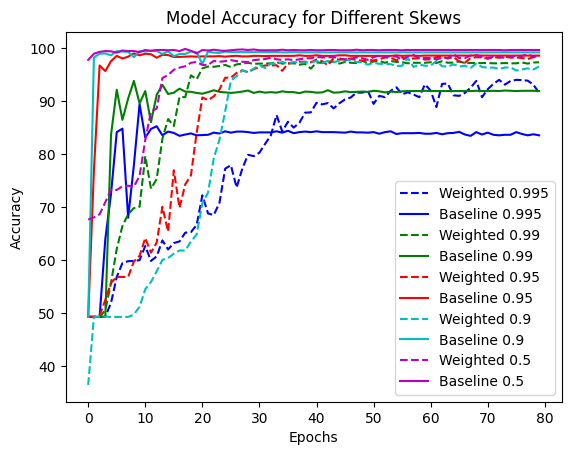

In [ ]:
meta_size = 10
batch_size_train, batch_size_test = 100, 128

splits = [0.995, 0.99, 0.95, 0.9, 0.5]
colors = ['b', 'g', 'r', 'c', 'm']
for split, color in zip(splits, colors):
  print(split)
  train_dataset, meta_dataset, test_dataset = nineAndFourDataset(copy.deepcopy(train_dataset_base), copy.deepcopy(test_dataset_base), split=split,  meta_size=meta_size)
  # Create dataloaders

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)
  meta_loader = torch.utils.data.DataLoader(meta_dataset, batch_size=100, shuffle=True)
  meta_loader = itertools.cycle(meta_loader)
  meta_data = torch.autograd.Variable(meta_dataset.data, requires_grad=False)
  meta_labels = torch.autograd.Variable(meta_dataset.targets, requires_grad=False)
  meta_acc = meta_assessModel()
  base_acc = assessModel()
  plt.plot(meta_acc, color = color, linestyle="dashed", label = "Weighted "+str(split))
  plt.plot(base_acc, color = color, label="Baseline "+str(split))
  
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy for Different Skews")